# Action recognition course : LAB 2

> Author : BABIN-RIBY Hugo, See LICENSE FIle

This lab is meant to be completed by students. There is a set of challenges they need to overcome by asking questions to gain experience.

> Note that this notebook was meant to be executed in google colab but can easily be ported to other services with minimal work.

At the end of this notebook (~1h30-2h) you will :

- Have a better expertise in video data inference
- Have hands-on experience with
  - action recognition models
  - action recognition datasets
- Know the pros and cons of each type of architecture

## Step 1 : get shoplifting data

- to test inference

In [1]:
!pip install kaggle;
!mkdir -p ~/.kaggle;
!cp kaggle.json ~/.kaggle/;
!chmod 600 ~/.kaggle/kaggle.json;
!kaggle datasets download -d mateohervas/dcsass-dataset -p /content/;
!unzip /content/dcsass-dataset.zip -d /content/;

Streaming output truncated to the last 5000 lines.
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_30.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_31.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_4.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_5.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_6.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_7.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_8.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery142_x264.mp4/Robbery142_x264_9.mp4  
  inflating: /content/dcsass dataset/DCSASS Dataset/Robbery/Robbery145_x264.mp4/Robbery145_x264_0.mp4  
  inflating

## Import Slowfast pretrained on kintetics400

+Some imports & utilities

In [2]:
import torch
!pip install pytorchvideo
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 59.7 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188685 sha256=1049836796e5f4ea6b4f1b96174da787da5382914ecbc7c9dad5e0e3f8baeac1
  Stored in directory: /root/.cache/pip/wheels/a4/6d/ae/d016375a73be141a0e11bb42289e2d0b046c35687fc8010ecc
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=3045741015030c38eb5673350381fa4ed0f690691f19633f12d98c77ac163834
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel 

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOWFAST_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOWFAST_8x8_R50.pyth
100%|██████████| 264M/264M [00:01<00:00, 190MB/s]


In [3]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


## 3 Declare slowfast transform

In [4]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3
clip_duration = (num_frames * sampling_rate)/frames_per_second

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

## Test inputs and visualize data

cuda
'dcsass dataset'  'DCSASS Dataset'   dcsass-dataset.zip   fine_tune_model.pth   sample_data
torch.Size([3, 8, 256, 256])
torch.Size([3, 32, 256, 256])
torch.Size([1, 400])


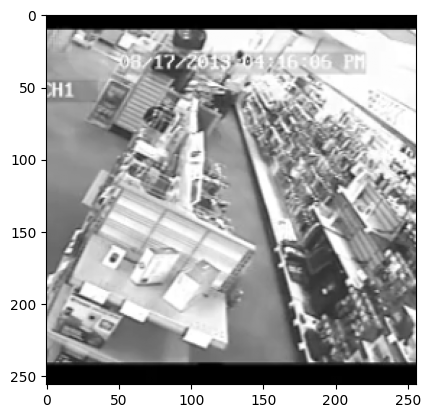

In [5]:
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

start_sec = 0
end_sec = start_sec + clip_duration

!ls

video = EncodedVideo.from_path("./DCSASS Dataset/Shoplifting/Shoplifting001_x264.mp4/Shoplifting001_x264_19.mp4")
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)
video_data = transform(video_data)
inputs = video_data["video"]

device = "cpu"

# Check a frame ...
print(inputs[0].shape)
print(inputs[1].shape)
plt.imshow(inputs[0][0][0].to("cpu"), cmap="gray")
plt.plot()

inputs = [i.to(device)[None, ...] for i in inputs]
model = model.to(device)

# Slowfast forward propagation
outputs = model(inputs)

print(outputs.shape)


## Declare the custom classifier

This is the model we'll train to fine tune SlowFast

In [6]:
import torch.nn as nn

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes=2):
        super(CustomClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.Dropout(0.5)
            ])
            prev_dim = dim

        layers.append(nn.Linear(prev_dim, num_classes))

        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

In [7]:
num_classes = 1 # [prob shoplifting]
slowfast_out = model.blocks[-1].proj.out_features
print(slowfast_out)

fine_tune = CustomClassifier(slowfast_out, [512, 128], num_classes)
print(fine_tune)

400
CustomClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [36]:
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import torch
import torch.nn.functional as F

class VideoDataset(Dataset):
    def __init__(self, video_folder, label_csv, transform=None, clip_duration=2):
        self.video_folder = video_folder
        self.data = pd.read_csv(label_csv, header=None, names=['Name', 'Type', 'Label'])
        self.data = self.data.drop(columns=['Type'])
        self.transform = transform
        self.clip_duration = clip_duration  # Duration of video clip in seconds

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_path = os.path.join(self.video_folder, row['Name'][0:19] + ".mp4/" + row['Name'] + ".mp4")
        label = row['Label']

        video = EncodedVideo.from_path(video_path)
        video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

        video_data = transform(video_data)['video']
        return video_data, label

# Create the full dataset
dataset = VideoDataset("./DCSASS Dataset/Shoplifting", "./DCSASS Dataset/Labels/Shoplifting.csv", transform, clip_duration)

# Calculate the sizes for train, validation, and test sets
# TRAIN | VALIDATION | TEST
#  75%  |    15%     |  10%
total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Print the sizes of each set
print("Train set size:", len(train_loader.dataset))
print("Validation set size:", len(val_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 672
Validation set size: 134
Test set size: 90


In [9]:
import torch.optim as optim
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tune = fine_tune.to(device)
model=model.to(device)

# criterion = CrossEntropyLoss()
# BINARY CROSS ENTROPY LOSS
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(fine_tune.parameters(), lr=0.0001)
print(device)

cuda


Epoch # 0  // Progress :  1.4705882352941178 % // Loss : 0.3437959849834442
Epoch # 0  // Progress :  2.9411764705882355 % // Loss : 0.6229919195175171
Epoch # 0  // Progress :  4.411764705882353 % // Loss : 0.7002550363540649
Epoch # 0  // Progress :  5.882352941176471 % // Loss : 0.45434412360191345
Epoch # 0  // Progress :  7.352941176470588 % // Loss : 0.39183077216148376
Epoch # 0  // Progress :  8.823529411764707 % // Loss : 0.6865304112434387
Epoch # 0  // Progress :  10.294117647058824 % // Loss : 0.20920062065124512
Epoch # 0  // Progress :  11.764705882352942 % // Loss : 0.19782960414886475
Epoch # 0  // Progress :  13.235294117647058 % // Loss : 0.5963066220283508
Epoch # 0  // Progress :  14.705882352941176 % // Loss : 1.1207534074783325
Epoch # 0  // Progress :  16.176470588235293 % // Loss : 0.13658063113689423
Epoch # 0  // Progress :  17.647058823529413 % // Loss : 0.49581632018089294
Epoch # 0  // Progress :  19.11764705882353 % // Loss : 0.3309169411659241
Epoch # 0  

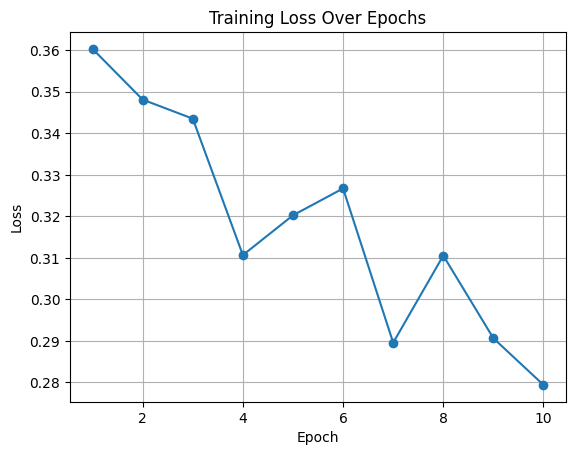

In [ ]:
torch.cuda.empty_cache()

# Initialize a list to store the running loss values
epoch_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.eval()
    fine_tune.train()
    running_loss = 0.0

    i = 0

    for inputs, labels in train_loader:
        i += 1
        slow_pathway = inputs[0].to(device)
        fast_pathway = inputs[1].to(device)
        labels = labels.to(device)
        outputs = model([slow_pathway, fast_pathway])

        classification = fine_tune(outputs)
        # print(classification,  torch.reshape(labels,classification.shape).float())

        optimizer.zero_grad()
        loss = criterion(classification, torch.reshape(labels,classification.shape).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print("Epoch #",epoch, " // Progress : ",100*i/len(train_loader), "% // Loss :", loss.item())

    # Calculate the average loss for this epoch and store it
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")

# Plot the running loss after the training loop
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [10]:
# torch.save(fine_tune.state_dict(), 'fine_tune_model.pth')
fine_tune.load_state_dict(torch.load('fine_tune_model.pth'))

<ipython-input-10-69334ddb2cb5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tune.load_state_dict(torch.load('fine_tune_model.pth'))


<All keys matched successfully>

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
# device="cpu"
torch.cuda.empty_cache()

model.to(device)
fine_tune.to(device)

model.eval()
fine_tune.eval()

num_tests = 100
correct_positive = 0
correct_negative = 0
test = 0
false_positive = 0
false_negative = 0

THRESHOLD = -0.8


for inputs, labels in val_loader:
    slow_pathway = inputs[0].to(device)
    fast_pathway = inputs[1].to(device)
    labels = labels.to(device)
    outputs = model([slow_pathway, fast_pathway])
    classification = fine_tune(outputs)

    shoplifting_label = bool(labels[0])
    classification_label = bool(classification[0] > THRESHOLD)

    correct_positive += shoplifting_label and classification_label
    correct_negative += not shoplifting_label and not classification_label
    false_positive += not shoplifting_label and classification_label
    false_negative += shoplifting_label and not classification_label

    print(test+1,shoplifting_label, classification_label, " // ACCURACY TRACKING : ", correct_positive, correct_negative, false_positive, false_negative)

    test += 1
    if test == 99:
      break

KeyboardInterrupt: 

## Compute accuracy

In [33]:
# Calculate metrics
total_tests = test + 1
accuracy = (correct_positive + correct_negative) / total_tests
precision = correct_positive / (correct_positive + false_positive) if (correct_positive + false_positive) > 0 else 0
recall = correct_positive / (correct_positive + false_negative) if (correct_positive + false_negative) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Confusion Matrix
confusion_matrix = {
    'True Positives': correct_positive,
    'True Negatives': correct_negative,
    'False Positives': false_positive,
    'False Negatives': false_negative
}

# Print Results
print("\n--- Evaluation Metrics ---")
print(f"Total Tests: {total_tests}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print("\n--- Confusion Matrix ---")
for key, value in confusion_matrix.items():
    print(f"{key}: {value}")


--- Evaluation Metrics ---
Total Tests: 100
Accuracy: 0.9200
Precision: 0.6667
Recall: 0.7273
F1 Score: 0.6957

--- Confusion Matrix ---
True Positives: 8
True Negatives: 84
False Positives: 4
False Negatives: 3


## Compute optimal threshold

Streaming output truncated to the last 5000 lines.
83.07692307692308  % ...
83.84615384615384  % ...
84.61538461538461  % ...
85.38461538461539  % ...
86.15384615384616  % ...
86.92307692307692  % ...
87.6923076923077  % ...
88.46153846153847  % ...
89.23076923076923  % ...
90.0  % ...
90.76923076923077  % ...
91.53846153846153  % ...
92.3076923076923  % ...
93.07692307692308  % ...
93.84615384615384  % ...
94.61538461538461  % ...
95.38461538461539  % ...
96.15384615384616  % ...
96.92307692307692  % ...
97.6923076923077  % ...
98.46153846153847  % ...
99.23076923076923  % ...
... Evaluating metrics for threshold :  -1.510204081632653
0.0  % ...
0.7692307692307693  % ...
1.5384615384615385  % ...
2.3076923076923075  % ...
3.076923076923077  % ...
3.8461538461538463  % ...
4.615384615384615  % ...
5.384615384615385  % ...
6.153846153846154  % ...
6.923076923076923  % ...
7.6923076923076925  % ...
8.461538461538462  % ...
9.23076923076923  % ...
10.0  % ...
10.76923076923077  % ...
11.5

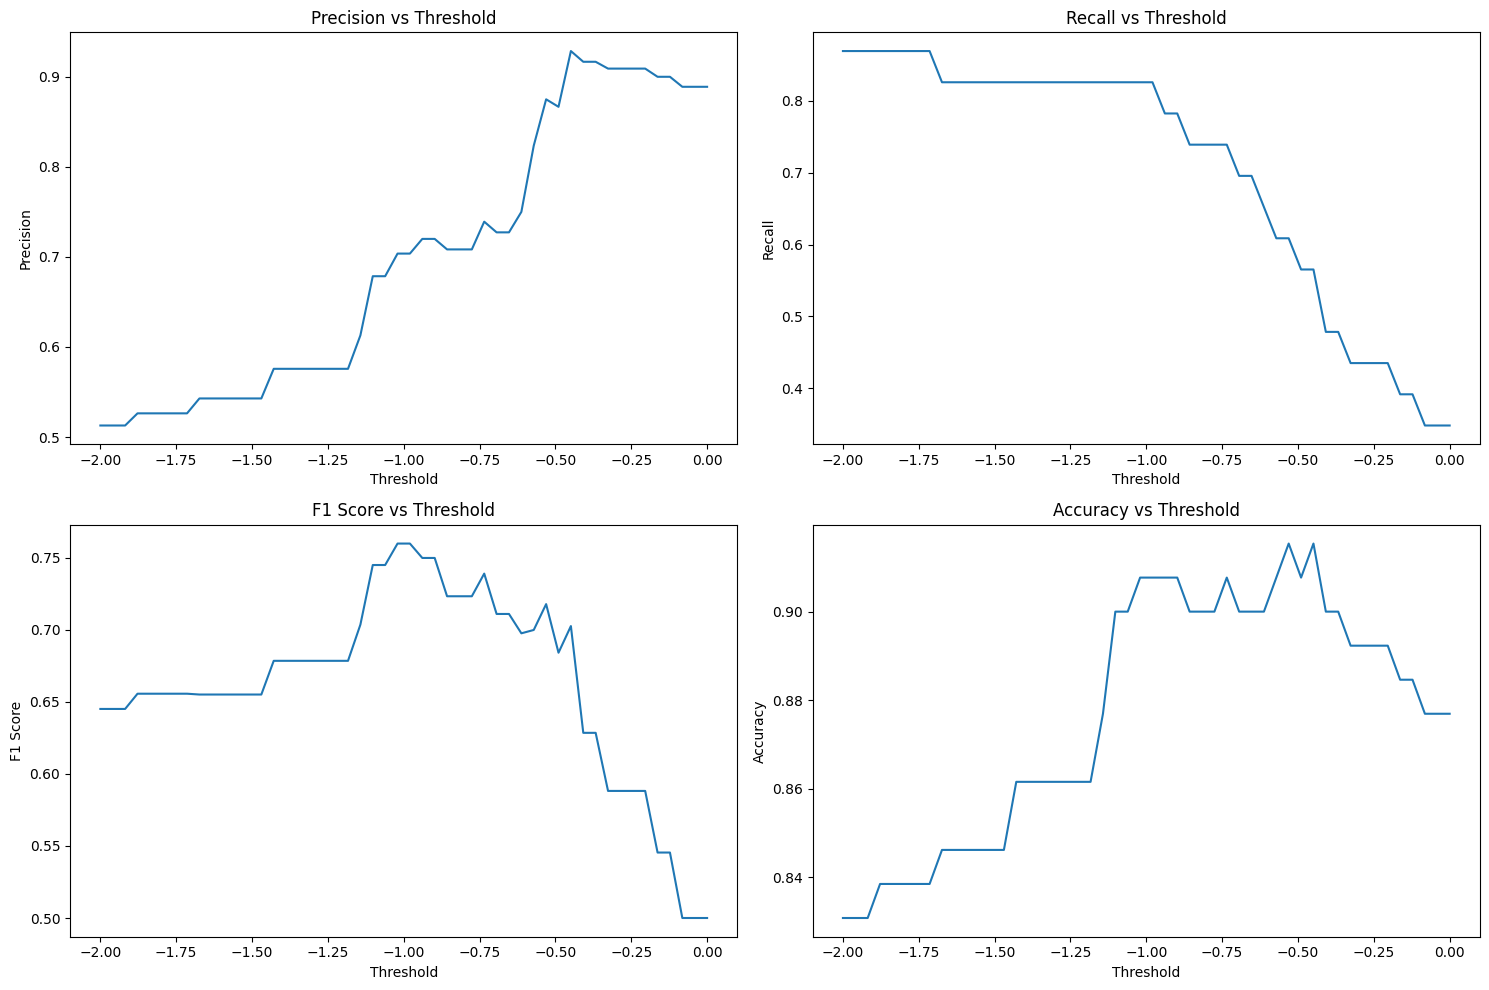


--- Optimal Thresholds ---
Precision Optimal:
Threshold: -0.4490
Precision: 0.9286
Recall: 0.5652
F1 Score: 0.7027
Accuracy: 0.9154

F1 Score Optimal:
Threshold: -1.0204
Precision: 0.7037
Recall: 0.8261
F1 Score: 0.7600
Accuracy: 0.9077

Accuracy Optimal:
Threshold: -0.5306
Precision: 0.8750
Recall: 0.6087
F1 Score: 0.7179
Accuracy: 0.9154


In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_threshold(val_loader, model, fine_tune, device, threshold):
    model.eval()
    fine_tune.eval()

    print("... Evaluating metrics for threshold : ", threshold)

    correct_positive = 0
    correct_negative = 0
    test = 0
    todo_tests = 130
    false_positive = 0
    false_negative = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            print(100*test/todo_tests, " % ...")
            slow_pathway = inputs[0].to(device)
            fast_pathway = inputs[1].to(device)
            labels = labels.to(device)

            outputs = model([slow_pathway, fast_pathway])
            classification = fine_tune(outputs)

            # Original threshold logic
            shoplifting_label = bool(labels[0])
            classification_label = bool(classification[0] > threshold)

            # Update metrics
            correct_positive += shoplifting_label and classification_label
            correct_negative += not shoplifting_label and not classification_label
            false_positive += not shoplifting_label and classification_label
            false_negative += shoplifting_label and not classification_label

            test += 1
            if test == todo_tests:
                break

    # Calculate metrics
    precision = correct_positive / (correct_positive + false_positive) if (correct_positive + false_positive) > 0 else 0
    recall = correct_positive / (correct_positive + false_negative) if (correct_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (correct_positive + correct_negative) / test

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'accuracy': accuracy,
        'correct_positive': correct_positive,
        'correct_negative': correct_negative,
        'false_positive': false_positive,
        'false_negative': false_negative,
        'threshold': threshold
    }

def find_optimal_threshold(val_loader, model, fine_tune, device):
    # Define a range of thresholds to test
    thresholds = np.linspace(-2, 0, 50)  # Adjusted range based on your original threshold
    results = []

    # Evaluate each threshold
    for threshold in thresholds:
        metrics = evaluate_threshold(val_loader, model, fine_tune, device, threshold)
        results.append(metrics)

    # Convert results to DataFrame for easy analysis
    import pandas as pd
    df_results = pd.DataFrame(results)

    # Plot metrics
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(df_results['threshold'], df_results['precision'])
    plt.title('Precision vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')

    plt.subplot(2, 2, 2)
    plt.plot(df_results['threshold'], df_results['recall'])
    plt.title('Recall vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')

    plt.subplot(2, 2, 3)
    plt.plot(df_results['threshold'], df_results['f1_score'])
    plt.title('F1 Score vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')

    plt.subplot(2, 2, 4)
    plt.plot(df_results['threshold'], df_results['accuracy'])
    plt.title('Accuracy vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    # Find optimal threshold for different metrics
    optimal_precision = df_results.loc[df_results['precision'].idxmax()]
    optimal_f1 = df_results.loc[df_results['f1_score'].idxmax()]
    optimal_accuracy = df_results.loc[df_results['accuracy'].idxmax()]

    print("\n--- Optimal Thresholds ---")
    print("Precision Optimal:")
    print(f"Threshold: {optimal_precision['threshold']:.4f}")
    print(f"Precision: {optimal_precision['precision']:.4f}")
    print(f"Recall: {optimal_precision['recall']:.4f}")
    print(f"F1 Score: {optimal_precision['f1_score']:.4f}")
    print(f"Accuracy: {optimal_precision['accuracy']:.4f}")

    print("\nF1 Score Optimal:")
    print(f"Threshold: {optimal_f1['threshold']:.4f}")
    print(f"Precision: {optimal_f1['precision']:.4f}")
    print(f"Recall: {optimal_f1['recall']:.4f}")
    print(f"F1 Score: {optimal_f1['f1_score']:.4f}")
    print(f"Accuracy: {optimal_f1['accuracy']:.4f}")

    print("\nAccuracy Optimal:")
    print(f"Threshold: {optimal_accuracy['threshold']:.4f}")
    print(f"Precision: {optimal_accuracy['precision']:.4f}")
    print(f"Recall: {optimal_accuracy['recall']:.4f}")
    print(f"F1 Score: {optimal_accuracy['f1_score']:.4f}")
    print(f"Accuracy: {optimal_accuracy['accuracy']:.4f}")

    return {
        'precision_threshold': optimal_precision['threshold'],
        'f1_threshold': optimal_f1['threshold'],
        'accuracy_threshold': optimal_accuracy['threshold']
    }

# Usage
optimal_thresholds = find_optimal_threshold(val_loader, model, fine_tune, device)